In [1]:
import pandas
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import sklearn.feature_extraction as fe
import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
import sklearn.neighbors as nhb
import sklearn.ensemble as es
import sklearn.tree as tree
from sklearn import svm
import sklearn.naive_bayes as nb
import sklearn.linear_model as lm
from sklearn.metrics import classification_report, fbeta_score, make_scorer, log_loss, accuracy_score, roc_curve, brier_score_loss, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn.calibration as cl

%matplotlib inline

In [5]:
train = pandas.read_csv('data/account_histroy_data.csv')
test = pandas.read_csv('data/existing_account.csv')

In [7]:
test.head()

,CreditScore,Geography,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,763,France,0,23,2,0.00,2,1,0,153983.99
1,563,Spain,0,36,4,143680.47,2,1,1,63531.19
2,678,Spain,1,38,3,124483.53,1,1,0,126253.31
3,644,Spain,0,31,5,86006.30,1,1,1,73922.95
4,682,Germany,0,43,7,111094.05,2,1,1,64679.30


In [6]:
train = train.drop(labels = ['RowNumber', 'CustomerId', 'Surname'], axis=1)
train = train.replace({'Gender': {'Female': 0, 'Male': 1}})
train = train.rename(columns={'Gender': 'IsMale'})
test = test.drop(labels = ['CustomerId', 'Surname'], axis=1)
test = test.replace({'Gender': {'Female': 0, 'Male': 1}})
test = test.rename(columns={'Gender': 'IsMale'})

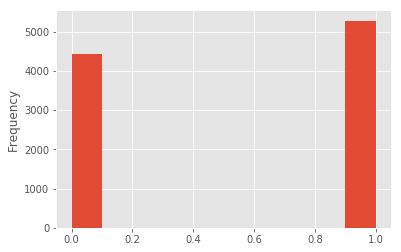

In [5]:
matplotlib.style.use('ggplot')
train['IsMale'].plot.hist()

# Initial analysis

* `RowNumber`, `CustomerID` and `Surname` can be dropped 
* `CreditScore` whilst numerical should be treated more like a ordinal variable. Nice and normal distribution. No missing values
* `Age` is nicely behaved: no missing values, nice and finite, nice and normally distributed
* `Tenure` is similarly nicely behaved: no missing values, finitely bounded and practically uniformally distributed. What does this variable represent? Age of account?
* `Balance` is a bit more interesting: there's a large spike at ~<= 30k and then a normally distributed group centered at just over 100k. This suggests 2 separate populations. No na values
* `NumOfProducts` is uninteresting: no missing values, all integers in [1,4]. All same order of magnitude
* `HasCrCard` binary variable indicating credit card ownership. No missing values. Distribution of both classes is same order of magnitude, positive value (`1`) outweighs `0` value by about 4k occurences.
* `IsActiveMember` binary variable. Practically class sizes. No missing values.
* `EstimatedSalary` nicely behaved: uniform distribution with no missing values and all values in the same order of magnitude.
* `Exited` Target variable. 1 indicates customer left, inbalanced classes with most cases in the "stayed" category.

# Potential process

* Given we don't have to worry about missing values, send the data straight to an `sklearn DictVectoriser` (as we want to track column names) followed by `OneHotEncoder` to handle binary variables that 
* This will automatically handle binarising our categorical variables.
* Most variables were normally or uniformally distributed, so standard scaling should be sufficient, but test with robust scaling as well.
* We've got enough data points that we can comfortable affort to slice off a portion of the dataset as a validation set. This can be done post scaling, pre test-train split. This will help prevent overfitting.
* The class imbalance isn't too bad (they're both on the same order of magnitude), but it would be worth testing over/under/synthetic sampling approaches anyways.
* We're treating this as a classification exercise, so let's run it across Naive Bayes, some forests of trees, gradient boosting, SVM's. As a baseline/sanity check let's run super basic logistic and single-tree models as well. ~~Bigger~~ Fancier isn't always better.
* Model stacking and voting classifiers (soft and hard) are also worth investigating

In [8]:
train[train['EstimatedSalary'].isna()]

,CreditScore,Geography,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


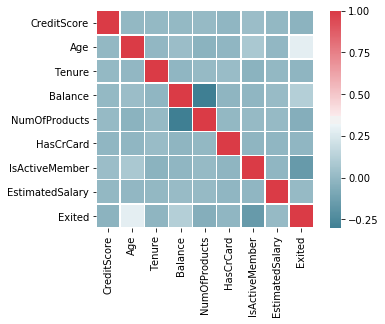

In [9]:
corr = train[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']].corr()
camp = sb.diverging_palette(220, 10, as_cmap=True)
sb.heatmap(corr, cmap=camp, square=True, linewidths=0.5)

# Correlation Matrix
While it appears pretty uniform at first glance, there's some interesting stuff lurking here: whilst most of the variables exhibit near 0 correlation, there's some positive correlation between `age` and `exited` and some (relatively) strong negative correlation between `NumOfProducts` and `Balance`. There's also a weak negative correlation between `IsActiveMember` and `Exited`; possibly too weak to be useful, but worth keeping in mind.

# Feature Engineering
Add some features that we think might add some extra information/structure to the dataset - models and feature selection will drop them back out if they turn out to not be useful.
* Balance / NumOfProducts?
* EstimatedSalary / NumOfProducts
* NumOfProducts / Tenure

In [10]:
train = train.assign(
    BalanceByProducts=(train['Balance'] / train['NumOfProducts']), 
    SalaryByProducts=(train['EstimatedSalary'] / train['NumOfProducts']))
test = test.assign(
    BalanceByProducts=(test['Balance'] / test['NumOfProducts']), 
    SalaryByProducts=(test['EstimatedSalary'] / test['NumOfProducts']))

In [11]:
# Let's slice off a validation set now so we can completely isolate it from the train and test data.
validation = train[['CreditScore', 'Geography', 'IsMale', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                    'EstimatedSalary','BalanceByProducts','SalaryByProducts', 'Exited']].sample(frac=0.1)
train2 = train[~train.index.isin(validation.index)]# Drop the validation values from the primary train set

In [12]:
train2.head()

,CreditScore,Geography,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceByProducts,SalaryByProducts
0,619,France,0,42,2,0.00,1,1,1,101348.88,1,0.000000,101348.880
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0,83807.860000,112542.580
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1,53220.266667,37977.190
3,699,France,0,39,1,0.00,2,0,0,93826.63,0,0.000000,46913.315
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0,125510.820000,79084.100


In [13]:
def sep_target(data):
    cols = data.columns
    target = data['Exited']
    rem = data[cols.drop('Exited')]
    return rem, target

def re_order_unbind(data): 
    re_ordering = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'BalanceByProducts', 'SalaryByProducts',
                   'IsMale', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain',]
    num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','BalanceByProducts', 'SalaryByProducts']
    cat_cols = ['IsMale', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain']
    data = data[re_ordering]
    numerical = data[num_cols]
    categorical = data[cat_cols]
    return numerical, categorical

def re_order_unbind_2(data):  # Should have just parametised the first function, oh well
    re_ordering = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'BalanceByProducts', 'SalaryByProducts',
                   'IsMale', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'meta_svm', 'meta_gb']
    num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary','BalanceByProducts', 'SalaryByProducts']
    cat_cols = ['IsMale', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'meta_svm', 'meta_gb']
    data = data[re_ordering]
    numerical = data[num_cols]
    categorical = data[cat_cols]
    return numerical, categorical

def scale_rebind(num, cat):
    scalefn = pp.StandardScaler()
    scaled = scalefn.fit_transform(num)
    return np.concatenate([scaled, cat], axis=1)

In [14]:
# Lots of algorithms expect (and perform better) when data is in the same scale. However, it doesn't much sense to scale categorical variables, so we re-order the dataset for ease of interpretation then separate it
# into numerical and categorical sections, scale the numerical data and then rejoin everything back into the one dataset. Turning it into a function means we have a nice, single place to change our scaling type
# later if we want to test other types.

X,Y = sep_target(train2)
tempX = pandas.get_dummies(X)  # Splits categorical/text columns containing n categories into n binary variables
Xn, Xc = re_order_unbind(tempX)
Xs = scale_rebind(Xn, Xc)

valX, valY = sep_target(validation)
temp_valX = pandas.get_dummies(valX)
valXn, valXc = re_order_unbind(temp_valX)
valXs = scale_rebind(valXn, valXc)

test2 = pandas.get_dummies(test)
testn, testc = re_order_unbind(test2)
tests = scale_rebind(testn, testc)

# Thoughts on ML/fitting process

We are trying to predict whether a user will leave/stop being a customer. We have a large choice of metrics with which to evaluate estimator performance. Measuring model confidence via probabilities would be ideal as it will let us generate the `log-loss` metric which means we can optimise for an estimator that is not "confidently wrong" which would result in lost clients. Outputting probabilities is also useful because it would give the sales/retention/etc team the ability to prioritise certain customers based on how likely they are to churn. `F1` or `Fbeta` score would probably be the next best metric to evaluate with. Weighting for `Fbeta` could go either way. On one hand we don't want to raise false-positives on clients that weren't going to churn because this wastes sales' effort (but has no negative effect on the customer), but weighting too heavily for precision could lead to potential churn-customers being lost in order for the model to preserve the accuracy of the ones it is confident in.

In [15]:
models = {
    'svm': svm.SVC(),
    'svm_poly': svm.SVC(),
    'knn': nhb.KNeighborsClassifier(),
    'naive_bayes': nb.GaussianNB(),
#     'decision_tree': tree.DecisionTreeClassifier(),
    'random_forest': es.RandomForestClassifier(),
    'adaBoost': es.AdaBoostClassifier(),
    'Gradient_Boosting': es.GradientBoostingClassifier(),
    'Logistic_Regression': lm.LogisticRegression()
    #'Voting classifier'
}

In [16]:
# {'C': 0.5, 'class_weight': 'balanced', 'coef0': 0.4, 'degree': 3, 'gamma': 0.3, 'kernel': 'poly', 'probability': True, 'random_state': 74}
svm_params = {'C': [1, 0.5, 0.1], 'kernel': ['linear', 'rbf',], 'gamma': ['auto', 0.3], 
             'probability': [True], 'class_weight': ['balanced', None], 'random_state': [74]}
svm_poly_params = {'C': [0.5, 0.8, 0.25], 'kernel': ['poly'], 'degree': [2,3,5], 'gamma': ['auto', 0.1, 0.3], 'coef0': [0, 0.4, 0.6],
                'probability': [True], 'class_weight': ['balanced', None], 'random_state': [74]},
knn_params = {'n_neighbors': [3, 5, 9, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['kd_tree']}
nb_params = None
tree_params = None
forest_params = {'n_estimators': [50, 80, 150, 200, 250], 'max_features': ['auto', None, 0.5,0.8], 'min_samples_split': [0.3, 0.5, 0.8],
                'bootstrap': [True, False], 'n_jobs': [-1], 'random_state': [74], 'class_weight': ['balanced', None, 'balanced_subsample'], 'warm_start': [False]}
ada_params = {'n_estimators': [30, 40, 50, 80, 100, 150], 'learning_rate': [0.1, 0.2, 0.3, 0.35, 0.25], 'random_state': [74]},
gb_params = {'learning_rate': [0.1, 0.05], 'n_estimators': [100, 200, 300, 400, 500, 600], 'max_depth': [3, 6, 10], 'min_samples_split': [0.5, 0.3, 0.75],
            'min_samples_leaf': [1,3, 0.5, 0.2], 'subsample': [0.5, 1], 'max_features': [None, 'auto'], 'random_state': [74]}
logistic_params = {'C': [1, 0.75, 0.6, 0.4], 'class_weight': ['balanced', None], 'random_state': [74], 'max_iter': [300], 'warm_start': [True, False]}
voting_params = None
params = {#'svm': svm_params,
          'svm_poly': svm_poly_params,
          'knn': knn_params,
#           'decision TREE': tree_params,
          #'random_forest': forest_params,
          'adaBoost': ada_params,
          'Gradient_Boosting': gb_params,
          'Logistic_Regression': logistic_params}
#           'Voting classifier': voting_params}  # Leave this one out until we've got some good models to vote with

In [470]:
# We're going to build the models to optimise for recall first, then model stack with the best one(s) and then build a 2nd generation of models optimising for precision/log-loss.
for model, parameters in params.items():
    print()
    print()
    print(f'Testing model: {model}')
    clf = GridSearchCV(estimator=models[model],
                       param_grid=parameters,
                       cv=5,
                       scoring='recall',
                       n_jobs=-1,
                      refit='recall')
    clf.fit(Xs, Y)
    print(clf.best_params_)
    print(clf.n_splits_)
    est = clf.best_estimator_
    y_pred = est.predict(valXs)
    print(classification_report(valY, y_pred))



Testing model: svm_poly
{'C': 0.25, 'class_weight': 'balanced', 'coef0': 0.4, 'degree': 3, 'gamma': 0.3, 'kernel': 'poly', 'probability': True, 'random_state': 74}
5
             precision    recall  f1-score   support

          0       0.90      0.80      0.85       758
          1       0.49      0.68      0.57       212

avg / total       0.81      0.78      0.79       970



Testing model: knn
{'algorithm': 'kd_tree', 'n_neighbors': 3, 'weights': 'distance'}
5
             precision    recall  f1-score   support

          0       0.85      0.92      0.88       758
          1       0.59      0.43      0.50       212

avg / total       0.79      0.81      0.80       970



Testing model: adaBoost
{'learning_rate': 0.35, 'n_estimators': 150, 'random_state': 74}
5
             precision    recall  f1-score   support

          0       0.85      0.96      0.90       758
          1       0.73      0.39      0.51       212

avg / total       0.82      0.84      0.82       970



Tes

# Preliminary Results:
* Plain SVM's performed average at best, with middling precision but good recall: `0.49` and `0.72` respectively and `0.58` for the f1 score.
* Polynomial SVM's performed better with improvements to precision, recall and f1 score: `0.5`, `0.74` and `0.6` respectively.
Optimising precision and recall is a tradeoff, but for our case, because we don't want to risk losing customers, we want to bias slightly towards recall.
* Plain random forests and adaBoost haven't been too suitable for our use-case: they both perform exceedingly well with regards to precision - scoring `0.81` and `0.94` respectively but very poorly when it comes to recall with both models scoring `<= 0.1` for the target value (left). This isn't ideal as it means that whilst their predictions for customers leaving are accurate (they're generating very few false positives), they're essentially underestimating/underpredicting the number of customers who would leave. That is, in production, they would not flag a large percentage of customers who are about to leave.
* There is an upside, we can still make use of the high precision of these models by using model-stacking. This is where we'll use a model (adaBoost and svm_poly in this case) to generate predictions for all samples in the greater training and validation set (`Xs` and `valXs`) and these add a column in each dataset. We'll then train another model using this new dataset, this allows us to guide/help successive models with extra information.

# Best models so far:
Polynomial SVM (for best recall)
```
{'C': 0.25, 'class_weight': 'balanced', 'coef0': 0.4, 'degree': 3, 'gamma': 0.3, 'kernel': 'poly', 'probability': True, 'random_state': 74}
5
             precision    recall  f1-score   support

          0       0.90      0.80      0.85       758
          1       0.49      0.68      0.57       212

avg / total       0.81      0.78      0.79       970``` 


Gradient Boosting Trees  (for best precision)
```
{'learning_rate': 0.05, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 0.3, 'n_estimators': 200, 'random_state': 74, 'subsample': 1}
5
             precision    recall  f1-score   support

          0       0.87      0.95      0.91       767
          1       0.72      0.45      0.55       203

avg / total       0.84      0.85      0.83       970```



In [16]:
#Confusion matrix
#Let's roll with the polynomial SVM for now, as that seems to have the best balance.

# Model Comparison

We've got a couple of models that perform quite well on the validation set, to compare them further we'll evaluate their scores in a couple of other metrics, notably log-loss, ROC area-under-curve and overall accuracy.

Check log-loss and ROC-AUC stats for these, then see if their probability-calibrated versions yield any improvements.

In [17]:
def basic_scoring(validation, y_true, model):
    y_predicted = model.predict(validation)
    probs_predicted = model.predict_proba(validation)
    log_loss_res = log_loss(y_true=y_true, y_pred=probs_predicted[:, 1])
    roc_auc_res = roc_curve(y_true=y_true, y_score=probs_predicted[:, 1])
    accuracy = accuracy_score(y_true=y_true, y_pred=y_predicted)
    # Regenerate precision and recall just so we can compare everything in one place
    prec = precision_score(y_true=y_true, y_pred=y_predicted)
    rec = recall_score(y_true=y_true, y_pred=y_predicted)
    cnfsn_matrix = confusion_matrix(y_true=y_true, y_pred=y_predicted)
    tn, fp, fn, tp = cnfsn_matrix.ravel()
#     Informedness = Sensitivity + Specificity − 1
    informedness = rec + (tp / (fp + tn)) - 1
#     Markedness = PPV + NPV − 1
    markedness = prec + (tn / (tn + fn)) - 1
    print(f'Log-loss: {log_loss_res}')
#     print(f'ROC-AUC: {roc_auc_res}') Exclude this for now, as a plot of the ROC curve is probably more useful
#     Add ROC curve plots
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {prec}')
    print(f'Recall: {rec}')
#     Add (normalised) confusion matrix plots here

Text(0.5,13.5095,'Predicted label')

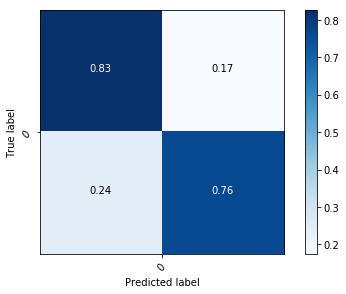

In [20]:
import itertools
temp = clf1.predict(valXs)
cfnm = confusion_matrix(valY, temp)
cfnm = cfnm/cfnm.sum(axis=1)[:, np.newaxis]
plt.imshow(cfnm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks([0.5], (0,1), rotation=45)
plt.yticks([0.5], (0,1), rotation=45)
thold = cfnm.max() / 2.
for i, j in itertools.product(range(cfnm.shape[0]), range(cfnm.shape[1])):
    plt.text(j, i, format(cfnm[i, j], '.2f'), horizontalalignment='center', color='white' if cfnm[i,j] > thold else 'black')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [21]:
svc = {'C': 0.25, 'class_weight': 'balanced', 'coef0': 0.4, 'degree': 3, 'gamma': 0.3, 'kernel': 'poly', 'probability': True, 'random_state': 74}
gbc = {'learning_rate': 0.05, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 0.3, 'n_estimators': 200, 'random_state': 74, 'subsample': 1}
clf1 = svm.SVC().set_params(**svc).fit(Xs, Y)
clf2 = es.GradientBoostingClassifier().set_params(**gbc).fit(Xs, Y)
print('SVM:')
basic_scoring(valXs, valY, clf1)
print()
print('Gradient Boosting:')
basic_scoring(valXs, valY, clf2)

SVM:
Log-loss: 0.3365321637546616
Accuracy: 0.8134020618556701
Precision: 0.5107913669064749
Recall: 0.7593582887700535

Gradient Boosting:
Log-loss: 0.31977003454912356
Accuracy: 0.8649484536082475
Precision: 0.7058823529411765
Recall: 0.5133689839572193


Both models exhibit some reasonably nice results. The SVM has been optimised for recall, and the gradient boost has been optimised for accuracy.
We'll run variable importance using the gradient boosting model and see if there's any variables we can drop. We'll then model stack using both models (i.e. add both models predictions to the training and validation sets) and then re-run with a model trained for accuracy or log-loss. Why model stack? Why isn't the gradient boosting/SVM model good enough on its own? In my opinion, the GB isn't good enough by itself because it misses a non-trivial portion of the positive cases. In a production environment, this would mean that while it's predictions for customers that will exit will be correct, there is a significant number of customers that it would miss. 
This is partially mitigated by low log-loss, which can be affected by outputting the probability of exit, rather than a yes/no for exit and then ranking customers by this probability because the models low log-loss translates into low confidence on incorrect cases which means that they will be near a decision boundary implying a moderate probability. This means Sales/retention/etc has more information on which customers to target rather than a bright-line yes/no. With these constraints/approaches in place, we could arguably stop here and just use the GB model with the mitigations in place, but I think we should go further.

The models have different strengths, so we're going to use both to build "meta" columns for our 2nd generation model.

* log-loss, which measures how "confident" a model is about incorrect results is quite an important metric: ideally, when the model incorrectly classifies a customer as "staying", we want it to do so in such a way that has these cases near the decision boundary (i.e. the probability of that case being "stay" is low", but not low enough to be cleanly classified as "exiting"). This means that when we rank the customers by probability of leaving, these customers will be near the middle, giving us more information to make a decision about who to follow up with beyond "will exit/won't exit".
    * Both models score well in this metric: `0.359` and `0.367` for the SVM and Gradient Boosting respectively. A lower score is better, with the metric having a lower bound at 0, representing a perfect score.
* Accuracy measures how many correct classifications were made across both classes. It is best viewed in combination with precision and recall to get a full picture of how well a model does what you wish (for example, you want an accurate model, but you . Higher scores are better, with the metric `[0,1]` bounded.
    * Both models perform well, with the GB having a small lead - `0.798` and `0.841` for the SVM and GB respectively
* Precision and Recall are a pair of metrics that measure "quality" and "quantity" respectively. Precision measures the fraction of cases marked as "positive" that were actually "positive". Recall measures the fraction of "positive" cases that were marked as "positive" by the classifier. Optimising a given classifier is a balance between these 2 metrics, as recall can be improved by essentially marking more cases as positive (which drives down precision) and precision can be boosted by essentially tightening decision boundaries to return fewer results but only correct ones (which would drive down recall, because you would be excluding valid "positive" cases). Once again, both metrics are `[0,1]` bounded and higher is better.
    * Precision for both classifiers is very good: `0.510` and `0.685` for the SVM and the Gradient Boosted models respectively.
    
# Conclusions
    
* Confusion matrix

In [22]:
clf1.predict(tests)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

In [331]:
# Maybe table the probability calibration for now, as we really don't care _that_ much for these models.

svc = {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.3, 'kernel': 'rbf', 'probability': True, 'random_state': 74}
gbc = {'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 0.3, 'n_estimators': 600, 'random_state': 74, 'subsample': 1}
clf1 = svm.SVC().set_params(**svc).fit(Xs, Y)
clf2 = es.GradientBoostingClassifier().set_params(**gbc).fit(Xs, Y)
basic_scoring(valXs, valY, clf1)
basic_scoring(valXs, valY, clf2)

svm_pc1 = cl.CalibratedClassifierCV(base_estimator=svm.SVC(), cv=5, method='sigmoid')
svm_pc2 = cl.CalibratedClassifierCV(base_estimator=svm.SVC().set_params(**svc), cv=5, method='sigmoid').fit(Xs, Y)
svm_pc3 = cl.CalibratedClassifierCV(base_estimator=clf1, cv='prefit', method='sigmoid')
gb_pc1 = cl.CalibratedClassifierCV(base_estimator=es.GradientBoostingClassifier(), cv=5, method='sigmoid').fit(Xs, Y)
gb_pc2 = cl.CalibratedClassifierCV(base_estimator=es.GradientBoostingClassifier().set_params(**gbc), cv=5, method='sigmoid').fit(Xs, Y)

uncalibratedSVM = clf1.predict_proba(valXs)[:,1]
uncalibratedGB = clf2.predict_proba(valXs)[:,1]
calibrated_svm1 = svm_pc1.fit(Xs, Y).predict_proba(valXs)[:, 1]
calibrated_svm2 = svm_pc2.fit(Xs, Y).predict_proba(valXs)[:, 1]
calibrated_gb1 = gb_pc1.fit(Xs, Y).predict_proba(valXs)[:,1]
calibrated_gb2 = gb_pc2.fit(Xs, Y).predict_proba(valXs)[:,1]

print(f'No calibration SVC: {brier_score_loss(valY, uncalibratedSVM)}')
print(f'Sigmoid calibration: {brier_score_loss(valY, calibrated_svm1)}')
print(f'Sigmoid calibration: {brier_score_loss(valY, calibrated_svm2)}')
print(f'No calibration Gradient Boosting: {brier_score_loss(valY, uncalibrated)}')
print(f'Sigmoid calibration: {brier_score_loss(valY, calibrated_gb1)}')
print(f'Sigmoid calibration: {brier_score_loss(valY, calibrated_gb2)}')


Log-loss: 8.296576935205211
Log-loss: 5.376689503838744
No calibration SVC: 0.11990238439982598
Sigmoid calibration: 0.11545138732209186
Sigmoid calibration: 0.12018441325708971
No calibration Gradient Boosting: 0.11048031215674682
Sigmoid calibration: 0.11118911776845422
Sigmoid calibration: 0.11178568295734097


In [19]:
metasvm = clf1.predict(Xs)
metagb = clf2.predict(Xs)

metasvm2 = clf1.predict(valXs)
metagb2 = clf2.predict(valXs)
train3 = train2.assign(meta_svm=metasvm, meta_gb=metagb)
valX2 = valX.assign(meta_svm=metasvm2, meta_gb=metagb2)
train3.head()

,CreditScore,Geography,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceByProducts,SalaryByProducts,meta_svm,meta_gb
0,619,France,0,42,2,0.00,1,1,1,101348.88,1,0.000000,101348.880,1,0
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0,83807.860000,112542.580,0,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1,53220.266667,37977.190,1,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0,0.000000,46913.315,0,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0,125510.820000,79084.100,0,0


In [20]:
valX2.head()

,CreditScore,Geography,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceByProducts,SalaryByProducts,meta_svm,meta_gb
5766,556,France,1,40,5,125909.85,1,1,1,95124.40,125909.850,95124.400,0,0
4498,570,France,1,30,2,131406.56,1,1,1,47952.45,131406.560,47952.450,0,0
3636,663,Spain,1,31,4,103430.11,2,0,1,36479.27,51715.055,18239.635,0,0
6363,678,Spain,0,40,4,113794.22,1,1,0,16618.76,113794.220,16618.760,0,0
7523,814,Spain,0,72,2,0.00,2,0,1,130853.03,0.000,65426.515,0,0


We can now re split-scale-recombine our datasets, then train a fancy new model! :D

In [21]:
tempt3 = pandas.get_dummies(train3)
tr3n, tr3c = re_order_unbind_2(tempt3)
train4 = scale_rebind(tr3n, tr3c)

tempvalx3 = pandas.get_dummies(valX2)
v3n, v3c = re_order_unbind_2(tempvalx3)
valX3 = scale_rebind(v3n, v3c)

In [28]:
models2 = {'svm': svm.SVC(), 'svm_poly_2': svm.SVC(), 'es': es.RandomForestClassifier(), 'ada': es.AdaBoostClassifier(), 'gb': es.GradientBoostingClassifier()}
svm2 = {'C': [0.1, 0.3, 0.5, 1], 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 0.3, 0.1, 0.7], 'probability': [True], 'class_weight': ['balanced', None], 'random_state': [74]}
svmpoly2 = {'C': [0.1, 0.3, 0.5, 1], 'kernel': ['poly'], 'degree': [3,4,5], 'gamma': ['auto', 0.3, 0.1, 0.7], 'probability': [True], 'class_weight': ['balanced', None], 'random_state': [74]}
forest2 = {'n_estimators': [10, 50, 100, 200], 'max_features': ['auto', 0.5, 0.8], 'class_weight': ['balanced', None]}
ada2 = {'n_estimators': [30, 40, 50, 80, 100, 150], 'learning_rate': [0.1, 0.2, 0.3, 0.35, 0.25], 'random_state': [74]}
# gb2 = {}
params2 = {'svm': svm2, 'svm_poly_2': svmpoly2, 'es': forest2, 'ada': ada2}

In [30]:
for model, parameters in params2.items():
    print()
    print()
    print(f'Testing model: {model}')
    clf = GridSearchCV(estimator=models2[model],
                       param_grid=parameters,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1,
                      refit='accuracy')
    clf.fit(train4, Y)
    print(clf.best_params_)
    print(clf.n_splits_)
    est = clf.best_estimator_
    y_pred = est.predict(valX3)
    print(classification_report(valY, y_pred))



Testing model: svm
{'C': 1, 'class_weight': None, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True, 'random_state': 74}
5
             precision    recall  f1-score   support

          0       0.86      0.95      0.90       769
          1       0.69      0.43      0.53       201

avg / total       0.83      0.84      0.83       970



Testing model: svm_poly_2


Process ForkPoolWorker-64:
Process ForkPoolWorker-56:
Process ForkPoolWorker-61:
Process ForkPoolWorker-58:
Process ForkPoolWorker-54:
Process ForkPoolWorker-63:
Process ForkPoolWorker-57:
Process ForkPoolWorker-52:
Process ForkPoolWorker-59:
Process ForkPoolWorker-50:
Process ForkPoolWorker-51:
Process ForkPoolWorker-60:
Process ForkPoolWorker-55:
Process ForkPoolWorker-62:
Process ForkPoolWorker-49:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File 

KeyboardInterrupt: 

In [25]:
meta_scoring = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc', 'neg_log_loss']
estimator = svm.SVC()
scores = cross_validate(estimator, train4, Y, cv=5, scoring=meta_scoring)
# clf2 = clf2.fit(X2, Y)
# res = clf2.predict(X2)
print(f'Accuracy: {scores["test_accuracy"]}')
print(f'F1: {scores["test_f1"]}')
print(f'Precision: {scores["test_precision"]}')
print(f'Recall: {scores["test_recall"]}')
print(f'Roc AUC: {scores["test_roc_auc"]}')
print(f'Log Loss: {scores["test_neg_log_loss"]*-1}')
print()
print(f'Accuracy average: {scores["test_accuracy"].mean()}')
print(f'F1 average: {scores["test_f1"].mean()}')
print(f'Precision average: {scores["test_precision"].mean()}')
print(f'Recall average: {scores["test_recall"].mean()}')
print(f'Roc AUC average: {scores["test_roc_auc"].mean()}')
print(f'Log loss average: {scores["test_neg_log_loss"].mean()*-1}')
print()
print('N.B. Higher value for log loss == bad. Better values approach 0')

Accuracy: [0.85746995 0.85746995 0.85100287 0.85787966 0.85616046]
F1: [0.64680851 0.64780764 0.64383562 0.65070423 0.64598025]
Precision: [0.65517241 0.65428571 0.62834225 0.65254237 0.64872521]
Recall: [0.63865546 0.64145658 0.66011236 0.6488764  0.64325843]
Roc AUC: [0.87155956 0.86360962 0.87326991 0.8617023  0.85983166]
Log Loss: [0.70244788 0.69901829 0.92062161 0.74426235 0.84080877]

Accuracy average: 0.8559965753817842
F1 average: 0.6470272488428235
Precision average: 0.6478135918828135
Recall average: 0.6464718471658326
Roc AUC average: 0.8659946103895901
Log loss average: 0.7814317805733448

N.B. Higher value for log loss == bad. Better values approach 0


In [ ]:
full = np.concatenate(Xs, valXs)
target = np.co